# Lab Assignment 3

**Computer Vision** - Term 5, 2022

Instructor: Dr. Saumya Jetly <br>
TA: Ribhu Lahiri

*Deadline: Friday, 18 March 2022 11:59 pm* 

Submission form link: https://forms.gle/aLT9AqtasQemhWMN9

Total points: 5 (with possible extra credit)


### Before Starting

Please download the FER-2013 dataset here: https://drive.google.com/file/d/1GTX0XYKtyOo9VADHL_AjLcp59si1aFkZ/view?usp=sharing

You will need it for the tasks that follow.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# ! unzip gdrive/MyDrive/fer2013.zip

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from skimage import color
from skimage.transform import resize
from skimage.feature import hog

In [5]:
# Reading in the dataset
df = pd.read_csv('gdrive/MyDrive/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
# Extract relevant data
x_data = pd.Series(df.pixels)
y_data = pd.Series(df.emotion)
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255 # Normalizing

In [7]:
# Reshape into 48x48 images
x_data = x_data.reshape(-1, 48, 48)
x_data.shape

(35887, 48, 48)

### Task 1: Creating histogram of Oriented Gradients (4 points)
The first task is to create the histogram of oriented gradients feature descriptor. There are two steps to it, the first is to create the oriented gradients from a given image which returns the magnitude and angle matrices. The next step then, is to use those matrices to create the histogram features.

You can refer to this blog as discussed in the lab session: https://iq.opengenus.org/object-detection-with-histogram-of-oriented-gradients-hog/

**Implement the `get_oriented_gradients` function** *(2 points)*

Use any sample image from the dataset to test out your function

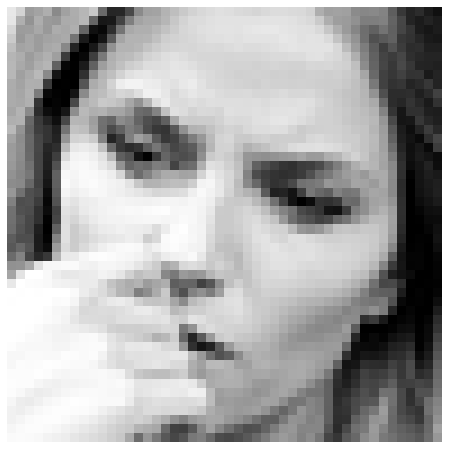

In [8]:
# Read in any image from the dataset
img = x_data[2]
plt.figure(figsize=(15, 8))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [9]:
print(img.shape)
print(img)
padded_img = np.zeros((50,50))
padded_img[1:1+img.shape[0],1:1+img.shape[1]] = img


(48, 48)
[[0.90588236 0.83137256 0.6117647  ... 0.17254902 0.10588235 0.0627451 ]
 [0.8980392  0.6862745  0.5803922  ... 0.10588235 0.13725491 0.10588235]
 [0.8392157  0.6117647  0.6156863  ... 0.10980392 0.08627451 0.10980392]
 ...
 [0.94509804 0.9607843  0.98039216 ... 0.22352941 0.39607844 0.57254905]
 [0.9647059  0.98039216 0.9882353  ... 0.30588236 0.4117647  0.63529414]
 [0.98039216 0.9843137  0.98039216 ... 0.34509805 0.43137255 0.59607846]]


In [10]:
img = np.array(img)
def get_oriented_gradients(img):
  '''
    Returns the magnitude and angles of the oriented gradients
    from the given image

    Parameters
    ----------
    img: np.ndarray
        The given image

    Returns
    -------
    mag: np.ndarray
        2-D Numpy array that contains the magnitudes of the oriented gradients

    theta: np.ndarray
        2-D Numpy array that contains the angles of the oriented gradients
  '''
  
  m,n = img.shape[0],img.shape[1]

  padded_img = np.zeros((m+2,n+2))
  padded_img[1:1+img.shape[0],1:1+img.shape[1]] = img
  mag, theta = np.zeros((m,n)), np.zeros((m,n))
  for i in range(1,m+1):
    for j in range(1,n+1):
      g_x = padded_img[i-1][j] - padded_img[i+1][j]
      g_y = padded_img[i][j+1] - padded_img[i][j-1]
      if g_x == 0.0:
        g_theta = 90
      g_mag = np.sqrt(g_x ** 2 + g_y ** 2)
      g_theta = (180/math.pi) * (np.arctan(g_y/g_x)%math.pi)
      if math.isnan(g_theta):
        g_theta = 0
      mag[i-1][j-1] = g_mag
      theta[i-1][j-1] = g_theta
       
  return mag, theta

In [11]:
mag, theta = get_oriented_gradients(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


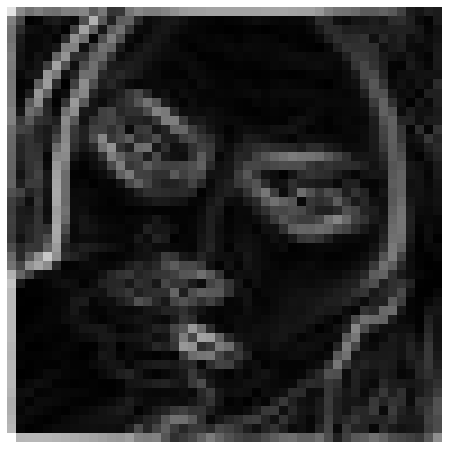

In [12]:
plt.figure(figsize=(15, 8))
plt.imshow(mag, cmap="gray")
plt.axis("off")
plt.show()

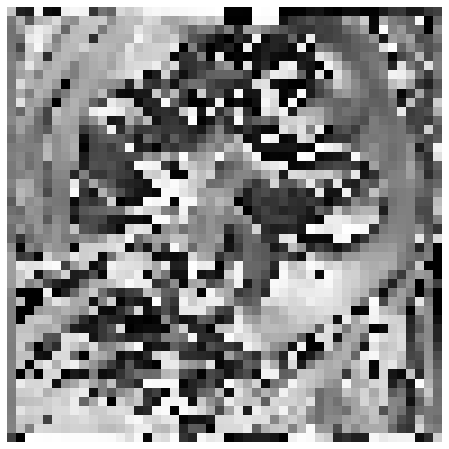

In [13]:
plt.figure(figsize=(15, 8))
plt.imshow(theta, cmap="gray")
plt.axis("off")
plt.show()

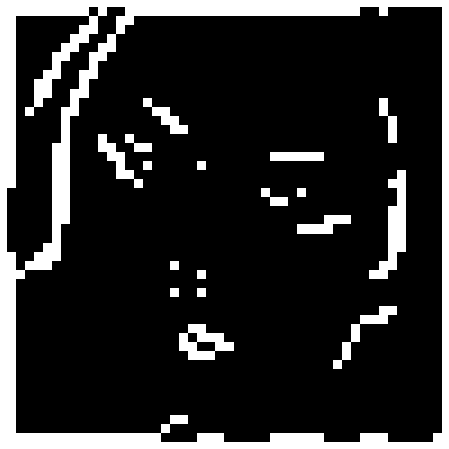

In [14]:
m_viz = (mag > 0.5).astype(float)
plt.figure(figsize=(15, 8))
plt.imshow(m_viz, cmap="gray")
plt.axis("off")
plt.show()

**Implement the `hog_features` function** *(2 points)*

Use the image, magnitudes, and angles of oriented gradients to bin them and create the HoG features to be used by our classifier

NOTE: While I have set the default value of number of bins as 9. Feel free to experiment and observe the effects of changing it on the downstream task

In [15]:
def create_hist(cell_mag,cell_theta,B = 9):
  '''
  Create a histogram of 9 bins from gradient magnitude and gradient orientation matrices.
  '''
  hist = np.zeros(9)
  m = cell_mag.shape[0]
  w = 180/B
  for i in range(m):
    for j in range(m):
      if cell_theta[i][j]%2 == 0 and cell_theta[i][j]%10 == 0:
        ind = int(cell_theta[i][j]//w)
        hist[ind] = cell_mag[i][j]
      elif cell_theta[i][j] > 160:
        ind1,ind2 = 0,8
        v1 = ((cell_theta[i][j]-160)/w) * cell_mag[i][j]
        hist[ind1] += v1
        hist[ind2] += cell_mag[i][j] - v1
      else:
        ind1 = int(cell_theta[i][j]//w)
        ind2 = ind1 + 1
        v1 = cell_mag[i][j]*((ind2*w - cell_theta[i][j])/w)
        hist[ind1] += v1
        hist[ind2] += cell_mag[i][j] - v1
    return hist


def hog_features(img,nbins=9):
  '''
    Create the histogram of oriented gradients feature vector

    Parameters
    ----------
    img: np.ndarray
        The given image

    nbins: int
        The number of buckets (bins) in which to organise the oriented gradients

    mag: np.ndarray
        2-D Numpy array that contains the magnitudes of the oriented gradients

    theta: np.ndarray
        2-D Numpy array that contains the angles of the oriented gradients

    Returns
    -------
    np.ndarray
        The HoG features 
        [given input of 48x48 images and 9 bins should be 1296]
    
  '''
  cell_hg = []
  mag, theta = get_oriented_gradients(img)

  # Creating a total of 36 histograms of 9 bins
  for i in range(0,img.shape[0],8):
    for j in range(0,img.shape[1],8):
      cell_mag = mag[i:i+8,j:j+8] 
      cell_theta = theta[i:i+8,j:j+8]
      hg = create_hist(cell_mag,cell_theta)
      cell_hg.append(hg)
  cell_hg = np.array(cell_hg)
  cell_hg = np.reshape(cell_hg,(6,6,9))
  feature_descriptor = []

  # Creating blocks of size 16x16
  for i in range(0,5):
    for j in range(0,5):
      block = cell_hg[i:i+2,j:j+2]
      block_vector = []
      for x in range(2):
        for y in range(2):
          cell_vec = block[x][y]
          block_vector.extend(block[x][y])
      # Normalising each block vector
      if np.linalg.norm(block_vector, ord=1)!=0:
        block_vector = block_vector/np.linalg.norm(block_vector, ord=1)
      feature_descriptor.extend(block_vector)
  return feature_descriptor 






In [16]:
print(math.floor(11/20-1/2)%9)

0


### Task 2: Using HoG with AdaBoost Classifier (1 points)
The second task is to create an AdaBoost classifier that uses the HoG features to classify the given images into one of 7 classes representing different emotions.

**Extra Credit:** Implement the AdaBoost Classifier from scratch, i.e. without using scikit-learn (1 points)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.3, 
                                                    random_state=42)
X_train.shape

(25120, 48, 48)

In [18]:
res = hog_features(X_train[411])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars


In [19]:
X_train = np.array([hog_features(im) for im in X_train])
X_test = np.array([hog_features(im) for im in X_test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


In [20]:
print(X_train.shape)

(25120, 900)


In [21]:
print(X_train.shape)

(25120, 900)


In [22]:
# In case you are attempting the extra-credit,
# use this class as reference for the bare-minimum functions
# you need to build

class AdaBoost:

  '''
    AdaBoost Classifier
  '''
  def __init__(self):
    pass
  
  def fit(self):
    pass

  def predict(self):
    pass

In [23]:
# TODO
np.random.seed(42)
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=200, random_state=0)

In [24]:
from sklearn.metrics import classification_report

y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.26      0.13      0.18      3486
           1       0.18      0.15      0.16       380
           2       0.25      0.12      0.16      3555
           3       0.40      0.65      0.49      6275
           4       0.27      0.20      0.23      4284
           5       0.33      0.35      0.34      2812
           6       0.30      0.33      0.32      4328

    accuracy                           0.33     25120
   macro avg       0.28      0.28      0.27     25120
weighted avg       0.31      0.33      0.30     25120



In [25]:
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.26      0.14      0.18      1467
           1       0.12      0.10      0.11       167
           2       0.28      0.14      0.19      1566
           3       0.40      0.63      0.49      2714
           4       0.24      0.17      0.20      1793
           5       0.31      0.35      0.33      1190
           6       0.28      0.31      0.29      1870

    accuracy                           0.32     10767
   macro avg       0.27      0.26      0.26     10767
weighted avg       0.30      0.32      0.30     10767

